**Updated**: 08.08.2021

In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
import tldextract
import seaborn as sns
import matplotlib

from colors import Colors
matplotlib.rc_file_defaults()

%matplotlib inline

In [2]:
connection = sq.connect("./measurements-all.db")
connection.row_factory = sq.Row

In [81]:
def buildExtractedDomain(extracted):
    result = ""
    if extracted.subdomain != "" and extracted.subdomain != "*":
        result += extracted.subdomain + "."
    if extracted.domain != "" and extracted.suffix != "":
        result += extracted.domain + "." + extracted.suffix
    return result

def mapToCommonName(info):
    commonName = buildExtractedDomain(tldextract.extract(info["CommonName"]))
    if commonName != "":
        return commonName
    if info["DNSNames"] == None:
        return None
    return buildExtractedDomain(tldextract.extract(info["DNSNames"][0]))

certs = pd.read_csv("certs.csv", converters={"info":json.loads}, header = None, names = ["ip", "protocol", "port", "info"])
quic_certs = certs
quic_certs["common_name"] = quic_certs["info"].apply(mapToCommonName)

### All QUIC Resolver

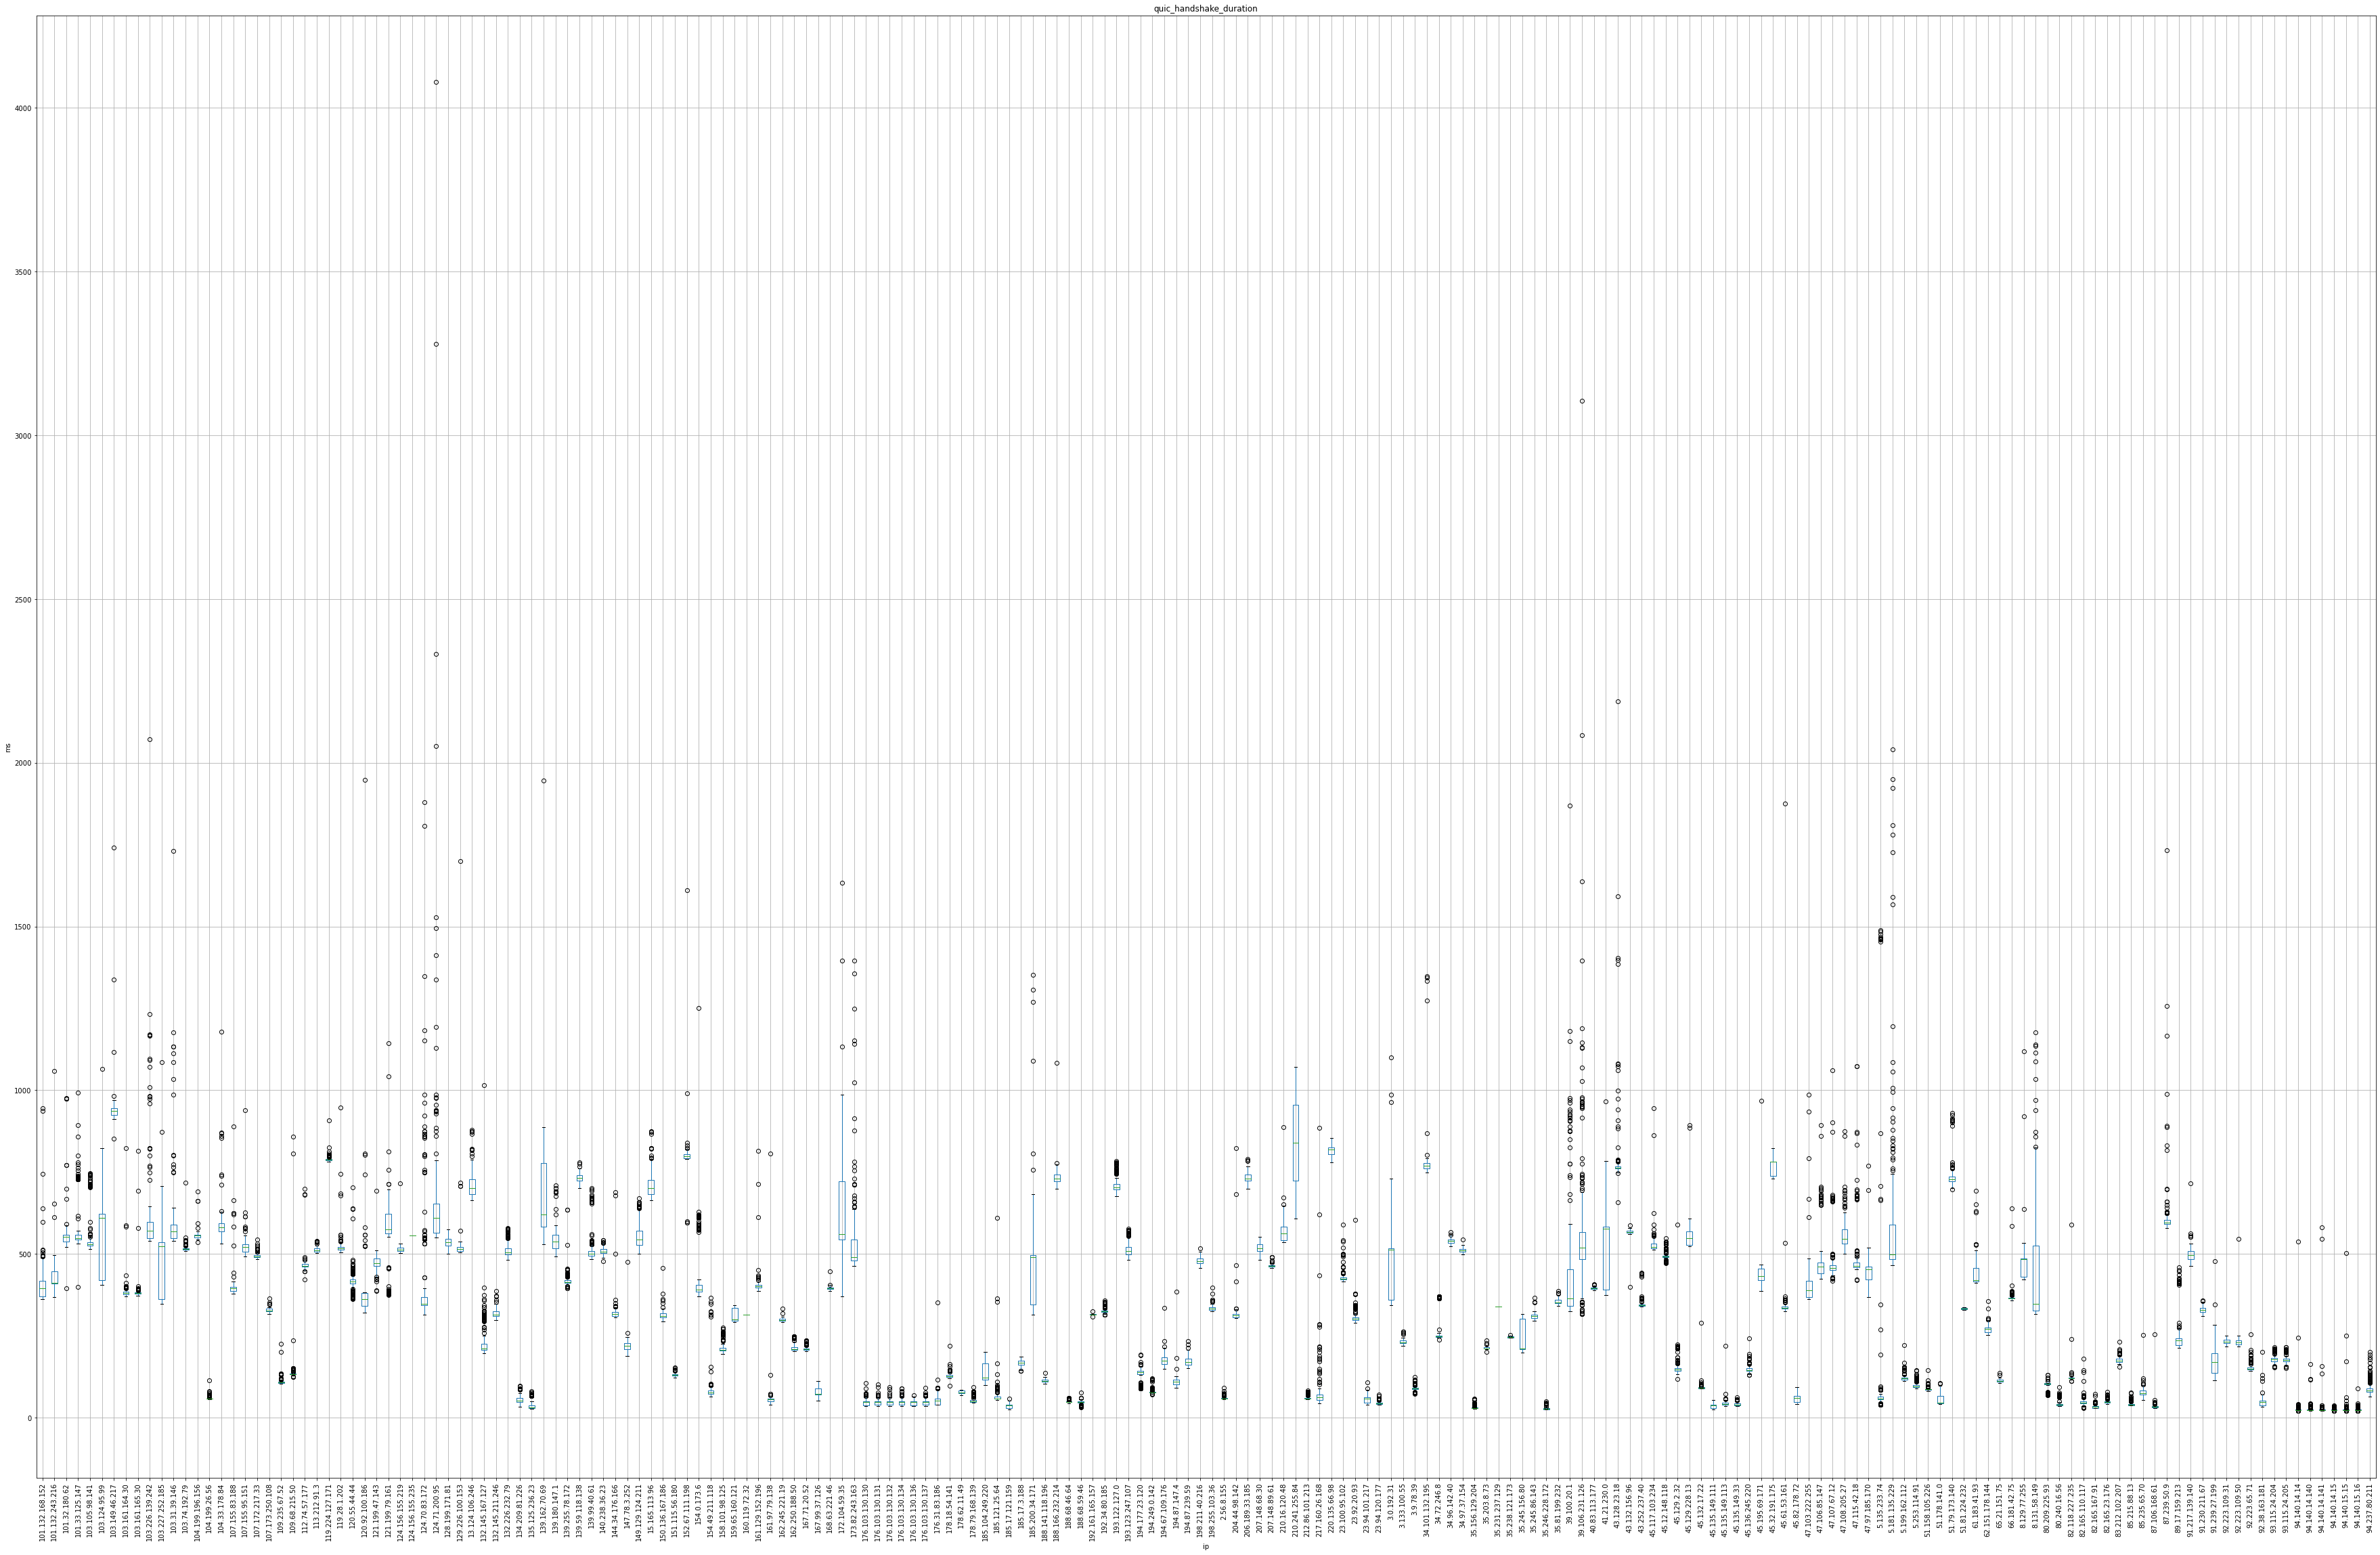

In [180]:
def getSetupTime():
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    sql = """
    SELECT ip, protocol, q_ui_c_handshake_duration / 1000000 as quic_handshake_duration, tcp_handshake_duration / 1000000 as tcp_handshake_duration, tls_handshake_duration / 1000000 as tls_handshake_duration, port FROM dns_measurements measurement
    WHERE measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
    """.format(*statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

setupTime = getSetupTime()
setupTime["tls_total"] = setupTime.apply(lambda row: row["tcp_handshake_duration"] + row["tls_handshake_duration"] if row["protocol"] == "tls" or row["protocol"] == "https" else None, axis = 1)
quicSetupTime = setupTime[setupTime["protocol"] == "quic"]
ax = quicSetupTime.boxplot(by = "ip", figsize = (60, 40), rot = 90, column = "quic_handshake_duration")

plt.suptitle("")
ax.set_ylabel("ms");

plt.savefig("figures/all_doq_resolver_handshake_boxplot.pdf", bbox_inches='tight')

In [82]:
largestVar = setupTime.groupby("ip")["quic_handshake_duration"].var().reset_index(name = "var").nlargest(20, "var")
smallestVar = setupTime.groupby("ip")["quic_handshake_duration"].var().reset_index(name = "var").nsmallest(20, "var")

### Largest Variance QUIC Resolver

(0.0, 5000.0)

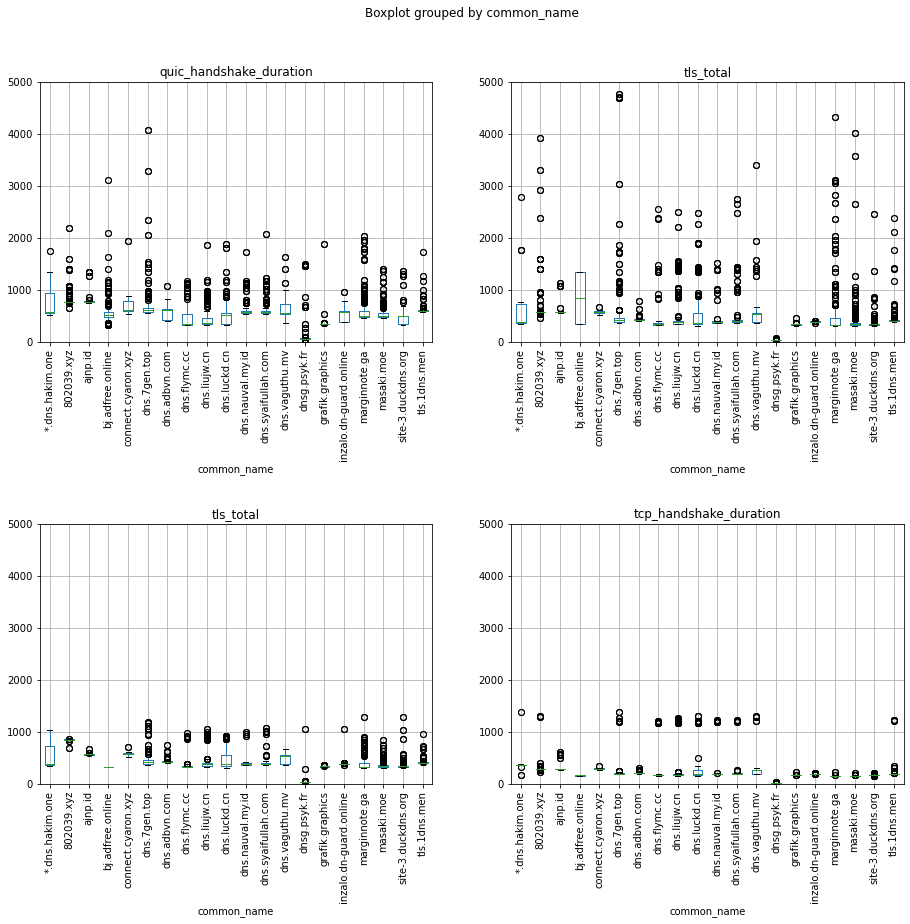

In [255]:
largestVarCommonName = pd.merge(setupTime, quic_certs, on = "ip")
largestVarCommonName = largestVarCommonName.groupby("common_name").agg({ "quic_handshake_duration": "var" }).nlargest(20, "quic_handshake_duration").reset_index()

largestValues = pd.merge(setupTime, quic_certs, on = ["ip"])

largestValues = largestValues[largestValues["common_name"].isin(largestVarCommonName["common_name"].unique())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 13))
fig.subplots_adjust(hspace=0.7)
ax = largestValues[largestValues["protocol_x"] == "quic"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 0], column = ["quic_handshake_duration"])
ax.set_ylim([0, 5000])
ax = largestValues[largestValues["protocol_x"] == "tls"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 1], column = ["tls_total"])
ax.set_ylim([0, 5000])
ax = largestValues[largestValues["protocol_x"] == "https"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 0], column = ["tls_total"])
ax.set_ylim([0, 5000])
ax = largestValues[largestValues["protocol_x"] == "tcp"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 1], column = ["tcp_handshake_duration"])
ax.set_ylim([0, 5000])

In [246]:
def mergeAll(items, key = "common_name"):
    temp = items[0]
    for i in range(1, len(items)):
        temp = pd.merge(temp, items[i], on = [key])
    return temp

def indexOfDispersion(group):
    return group.apply(lambda x: x.var() / x.mean())

#### Variances Compared

In [247]:
tcp = indexOfDispersion(largestValues[largestValues["protocol_x"] == "tcp"].groupby("common_name")["tcp_handshake_duration"]).reset_index(name = "TCP")
tls = indexOfDispersion(largestValues[largestValues["protocol_x"] == "tls"].groupby("common_name")["tls_total"]).reset_index(name = "TLS")
https = indexOfDispersion(largestValues[largestValues["protocol_x"] == "https"].groupby("common_name")["tls_total"]).reset_index(name = "HTTPS")
quic = indexOfDispersion(largestValues[largestValues["protocol_x"] == "quic"].groupby("common_name")["quic_handshake_duration"]).reset_index(name = "QUIC")

tb = mergeAll([tcp, tls, https, quic])
tb = tb.set_index("common_name")

In [248]:
tb

,TCP,TLS,HTTPS,QUIC
common_name,,,,
*.dns.hakim.one,13.422840,91.387063,66.123432,54.300932
802039.xyz,31.943728,216.347025,0.515544,24.679786
ajnp.id,11.893132,16.683987,0.263926,14.605012
bj.adfree.online,0.245187,395.588652,0.000000,126.038283
connect.cyaron.xyz,0.651033,1.228439,1.072688,25.727631
dns.7gen.top,110.988882,737.025762,46.918698,184.755134
dns.adbvn.com,0.909081,3.126750,3.044172,19.379078
dns.flymc.cc,379.116705,464.188242,31.546015,73.272268
dns.liujw.cn,376.019544,298.374282,65.160361,90.236873


In [249]:
def normalize_min_max(df):
    result = df.copy()
    max_values = df.max(axis = 1)
    min_values = df.min(axis = 1)
    for feature_name in df.columns:
        result[feature_name] = (df[feature_name] - min_values) / (max_values - min_values)
    return result

def normalize_mean(df):
    result = df.copy()
    mean = df.mean(axis = 1)
    std = df.std(axis = 1)
    for feature_name in df.columns:
        result[feature_name] = (df[feature_name] - mean) / std
    return result

normalized_tb = tb.div(tb.sum(axis=1), axis=0)

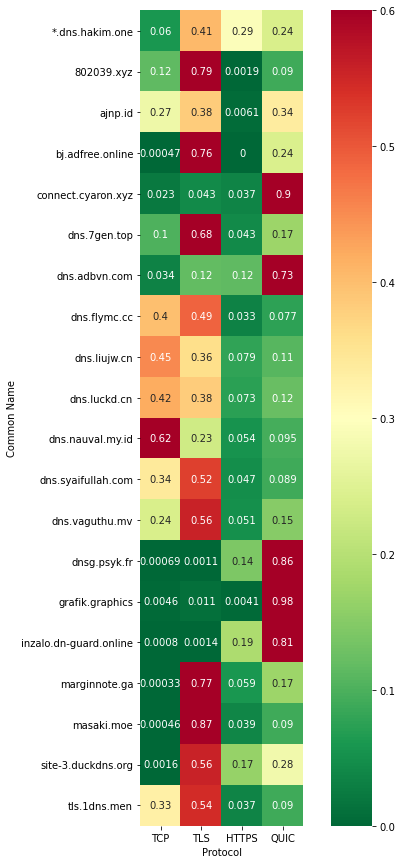

In [251]:
fig = plt.figure(figsize = (10, 15))
ax = sns.heatmap(normalized_tb, 
                 annot = True, square = True, 
                 vmax = 0.6,
                 cmap = sns.color_palette("RdYlGn_r", 5, as_cmap=True)
                )
ax.set(xlabel = "Protocol", ylabel = "Common Name")

plt.savefig("figures/highest_variance_heatmap.pdf", bbox_inches='tight')

#### Sample Size

In [203]:
counts = largestValues.groupby(["protocol_x", "common_name"]).size().reset_index(name = "size")
tcp = counts[counts["protocol_x"] == "tcp"].drop("protocol_x", axis = 1)
tcp.columns = ["common_name", "tcp"]
tls = counts[counts["protocol_x"] == "tls"].drop("protocol_x", axis = 1)
tls.columns = ["common_name", "tls"]
https = counts[counts["protocol_x"] == "https"].drop("protocol_x", axis = 1)
https.columns = ["common_name", "https"]
quic = counts[counts["protocol_x"] == "quic"].drop("protocol_x", axis = 1)
quic.columns = ["common_name", "quic"]
mergeAll([tcp, tls, https, quic])

,common_name,tcp,tls,https,quic
0,*.dns.hakim.one,439,1094,1084,1098
1,802039.xyz,663,660,201,663
2,ajnp.id,315,315,303,315
3,bj.adfree.online,4,4,2,436
4,connect.cyaron.xyz,168,165,168,660
5,dns.7gen.top,666,654,621,666
6,dns.adbvn.com,651,654,654,654
7,dns.flymc.cc,380,154,340,386
8,dns.liujw.cn,651,633,510,666
9,dns.luckd.cn,1083,905,990,1107


### Smallest Variance QUIC Resolver

<AxesSubplot:title={'center':'tcp_handshake_duration'}, xlabel='common_name'>

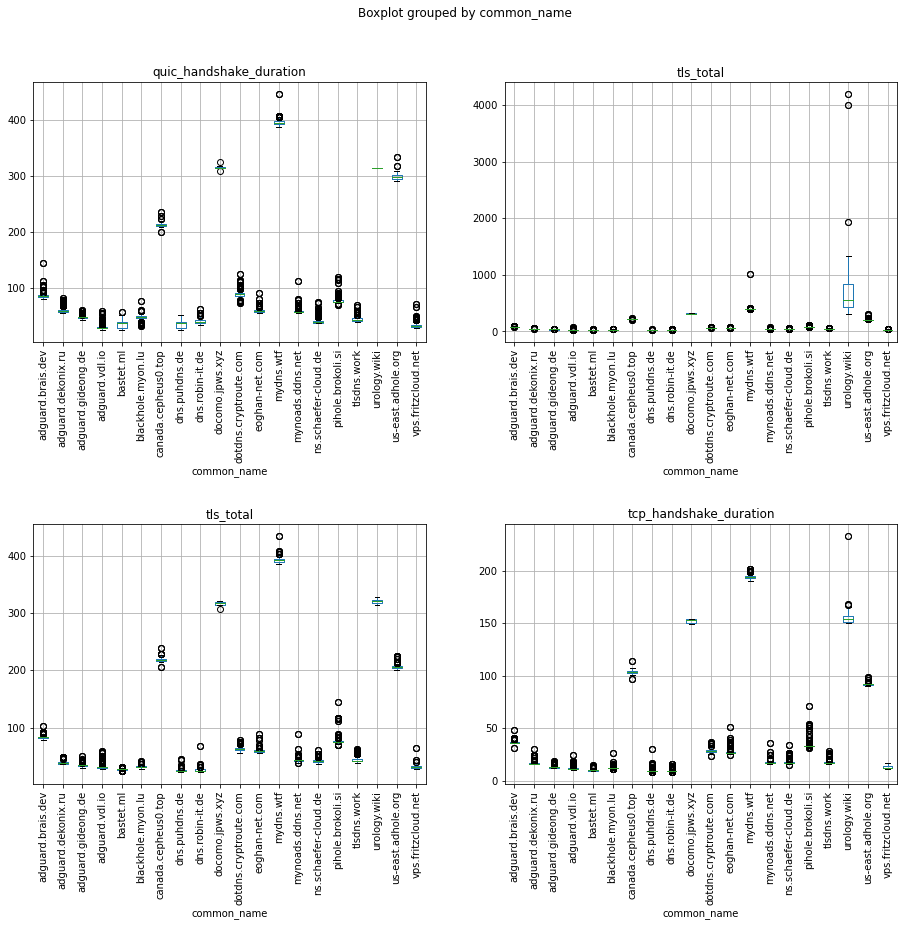

In [238]:
smallestVarCommonName = pd.merge(setupTime, quic_certs, on = "ip")
smallestVarCommonName = smallestVarCommonName.groupby("common_name").agg({ "quic_handshake_duration": "var" }).nsmallest(20, "quic_handshake_duration").reset_index()

smallestValues = pd.merge(setupTime, quic_certs, on = ["ip"])
smallestValues = smallestValues[smallestValues["common_name"].isin(smallestVarCommonName["common_name"].unique())]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 13))
fig.subplots_adjust(hspace=0.7)
smallestValues[smallestValues["protocol_x"] == "quic"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 0], column = ["quic_handshake_duration"])
smallestValues[smallestValues["protocol_x"] == "tls"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 1], column = ["tls_total"])
smallestValues[smallestValues["protocol_x"] == "https"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 0], column = ["tls_total"])
smallestValues[smallestValues["protocol_x"] == "tcp"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 1], column = ["tcp_handshake_duration"])

#### Variances Compared

In [239]:
tcp = indexOfDispersion(smallestValues[smallestValues["protocol_x"] == "tcp"].groupby("common_name")["tcp_handshake_duration"]).reset_index(name = "TCP")
tls = indexOfDispersion(smallestValues[smallestValues["protocol_x"] == "tls"].groupby("common_name")["tls_total"]).reset_index(name = "TLS")
https = indexOfDispersion(smallestValues[smallestValues["protocol_x"] == "https"].groupby("common_name")["tls_total"]).reset_index(name = "HTTPS")
quic = indexOfDispersion(smallestValues[smallestValues["protocol_x"] == "quic"].groupby("common_name")["quic_handshake_duration"]).reset_index(name = "QUIC")

tb = mergeAll([tcp, tls, https, quic])
tb = tb.set_index("common_name")

In [240]:
normalized_tb = tb.div(tb.sum(axis=1), axis=0)

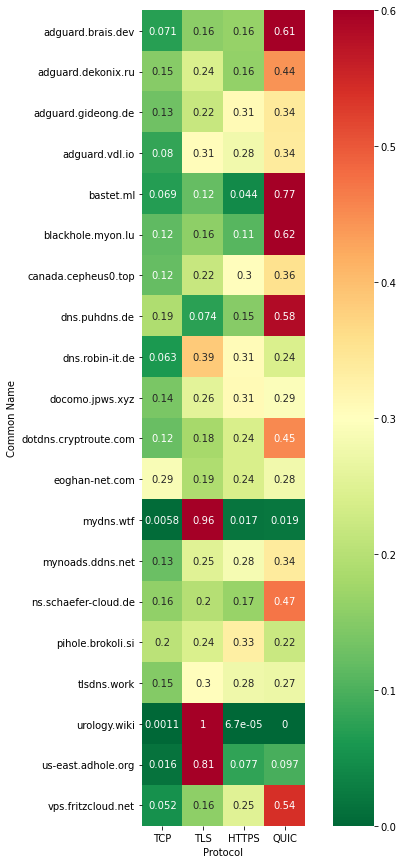

In [241]:
# sns.heatmap(tb.to_numpy())
fig = plt.figure(figsize = (10, 15))
ax = sns.heatmap(normalized_tb, 
                 annot = True, square = True, 
                 vmax = 0.6,
                 cmap = sns.color_palette("RdYlGn_r", 5, as_cmap=True)
                )
ax.set(xlabel = "Protocol", ylabel = "Common Name")

plt.savefig("figures/lowest_variance_heatmap.pdf", bbox_inches='tight')

#### Sample Size

In [208]:
counts = smallestValues.groupby(["protocol_x", "common_name"]).size().reset_index(name = "size")
tcp = counts[counts["protocol_x"] == "tcp"].drop("protocol_x", axis = 1)
tcp.columns = ["common_name", "tcp"]
tls = counts[counts["protocol_x"] == "tls"].drop("protocol_x", axis = 1)
tls.columns = ["common_name", "tls"]
https = counts[counts["protocol_x"] == "https"].drop("protocol_x", axis = 1)
https.columns = ["common_name", "https"]
quic = counts[counts["protocol_x"] == "quic"].drop("protocol_x", axis = 1)
quic.columns = ["common_name", "quic"]
mergeAll([tcp, tls, https, quic])

,common_name,tcp,tls,https,quic
0,adguard.brais.dev,666,666,666,666
1,adguard.dekonix.ru,666,666,666,666
2,adguard.gideong.de,666,525,666,492
3,adguard.vdl.io,666,666,666,666
4,bastet.ml,450,666,666,666
5,blackhole.myon.lu,666,666,666,666
6,canada.cepheus0.top,546,546,546,546
7,dns.puhdns.de,666,666,666,666
8,dns.robin-it.de,666,666,666,666
9,docomo.jpws.xyz,6,6,6,6


### All QUIC Resolver with Common Name

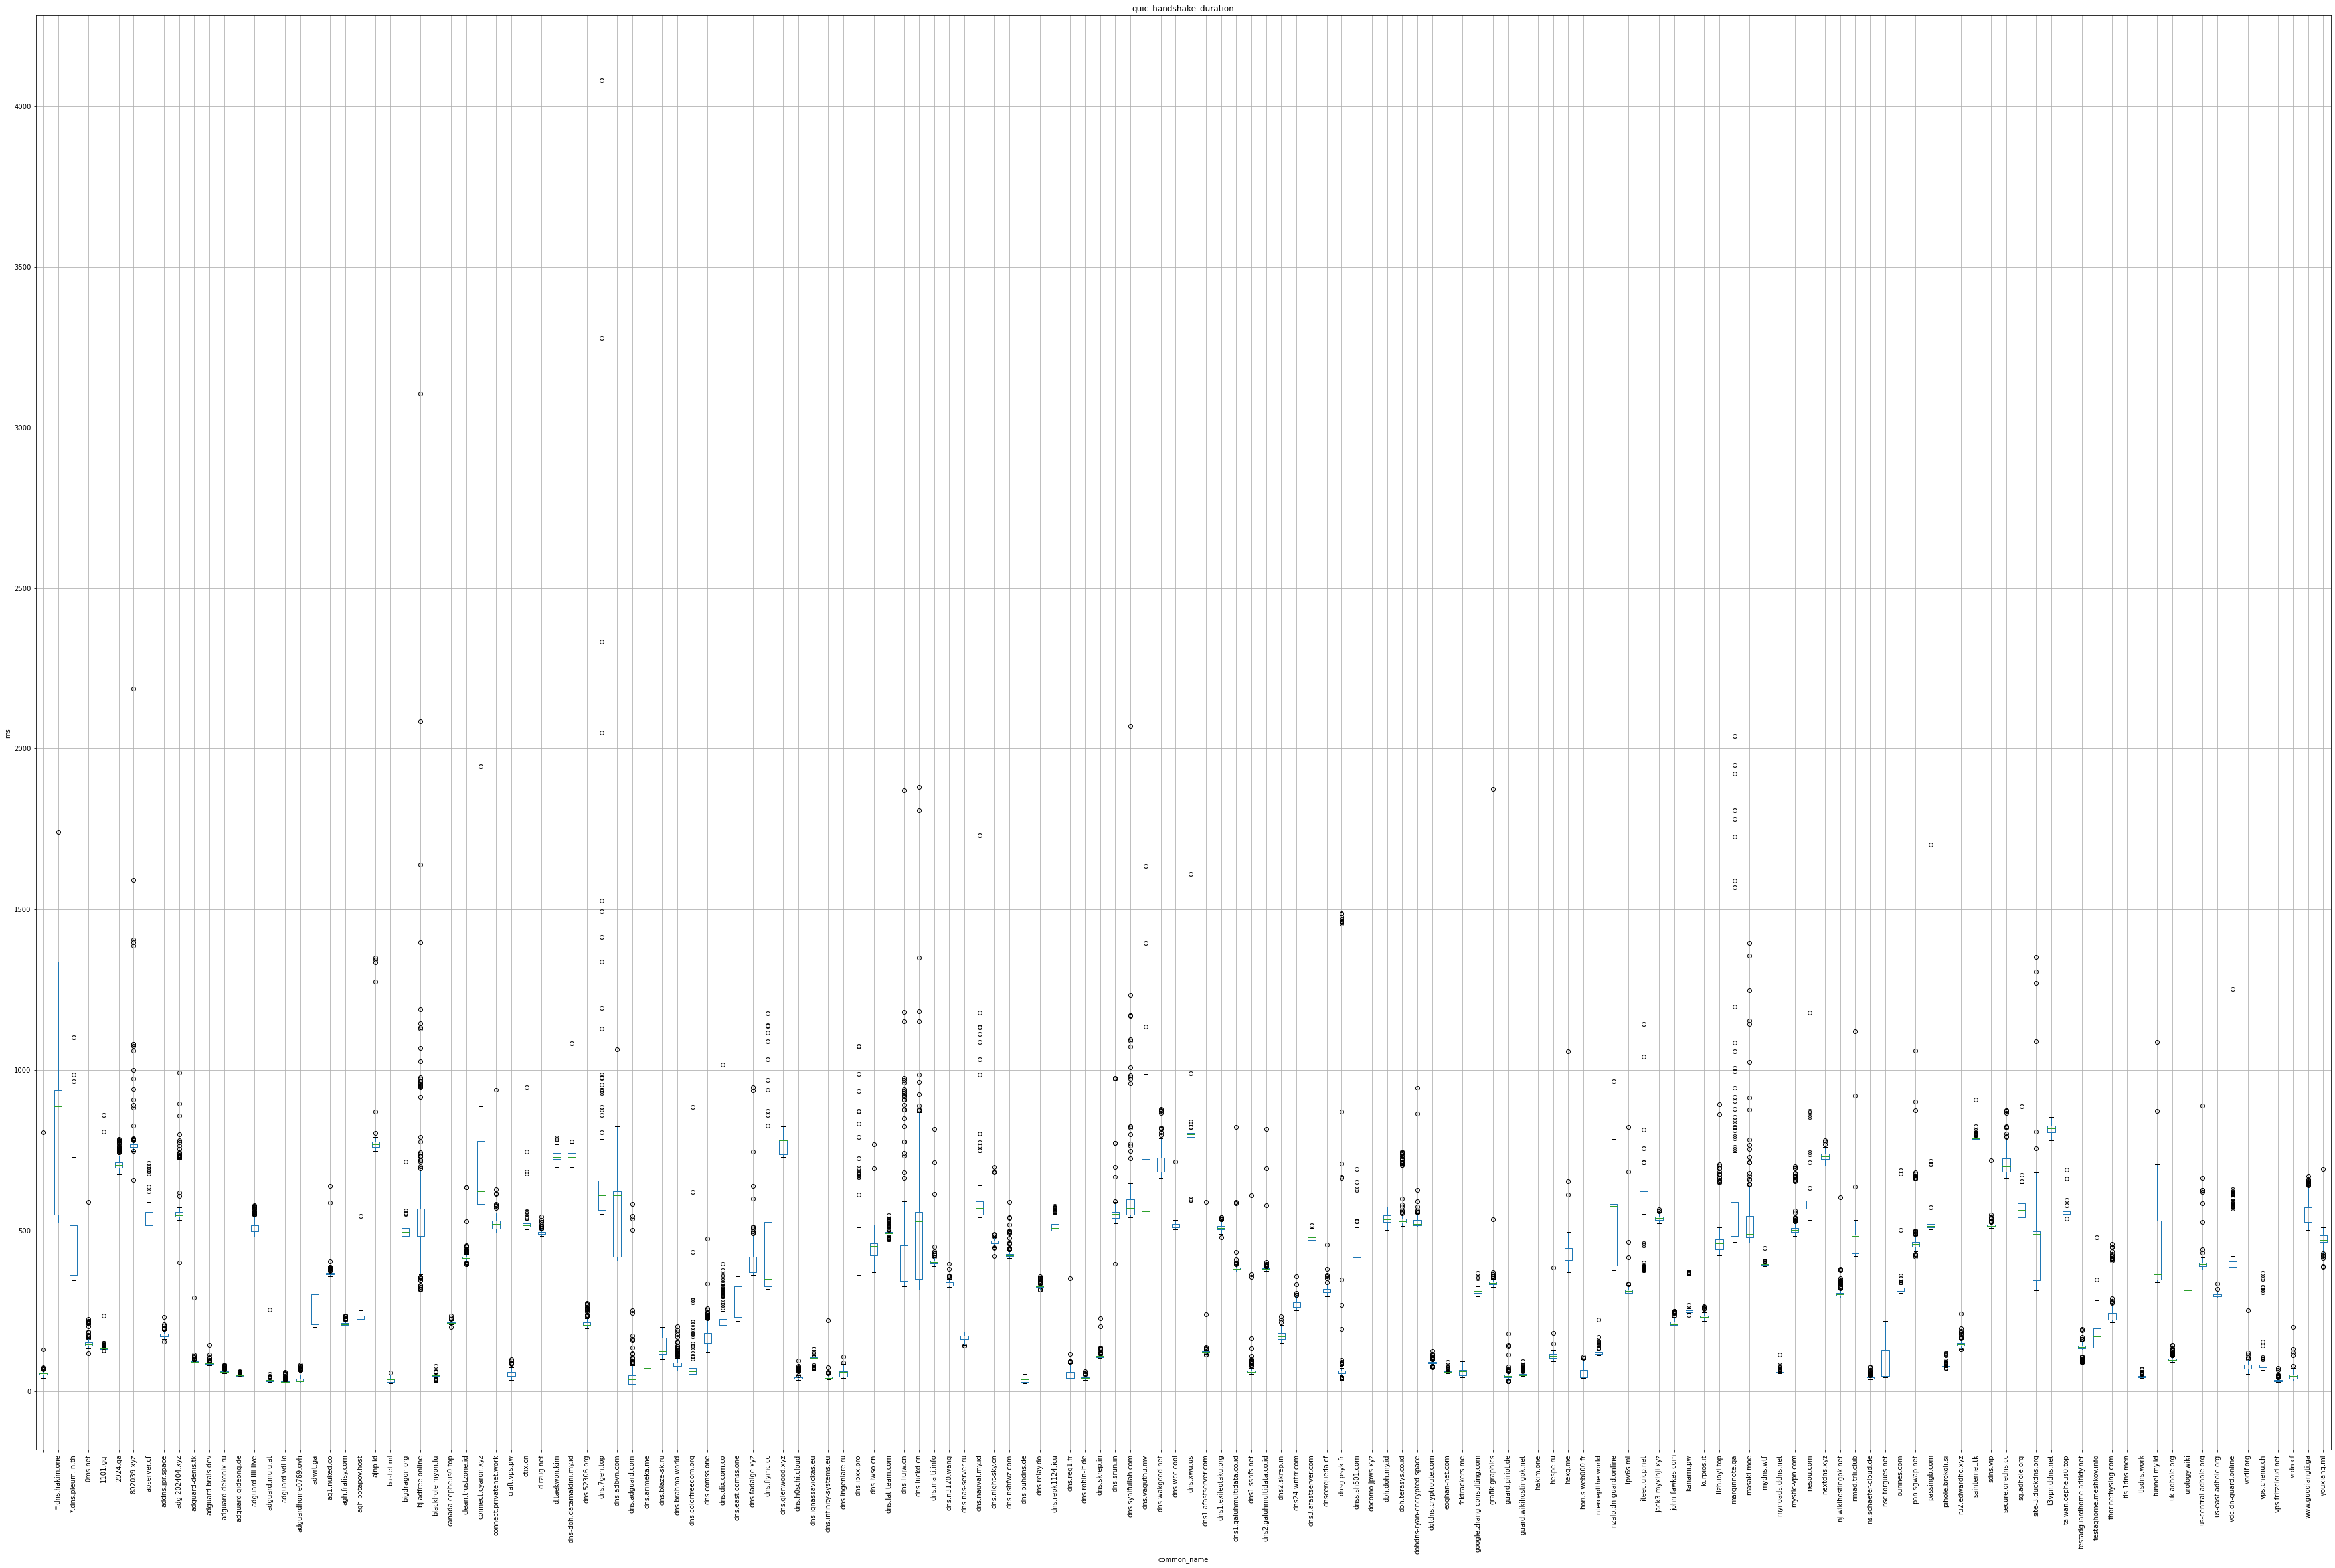

In [181]:
test = pd.merge(setupTime, quic_certs, on = ["ip", "port"])
ax = test.boxplot(by = "common_name", figsize = (60, 40), rot = 90, column = "quic_handshake_duration")

plt.suptitle("")
ax.set_ylabel("ms");
plt.savefig("figures/all_doq_resolver_handshake_common_name_boxplot.pdf", bbox_inches='tight')